In [22]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
import requests
import seaborn as sns
import statistics
import sys
import time
import wikipedia
from bs4 import BeautifulSoup
from collections import Counter
from copy import deepcopy
from itertools import combinations
from math import radians
from scipy import optimize
from scipy import stats
from scipy.spatial.distance import squareform
from scipy.special import zetac
from sklearn.neighbors import DistanceMetric
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import jaccard_score
import networkx as nx
from sklearn.metrics import classification_report

dist = DistanceMetric.get_metric('haversine')

**TO-DO:**

- Tupian lexical database case study -- https://tular.clld.org/
- Get WORDNET semantic field
- Study wold

### 1. Data loading and useful functions 

Load NorthEuraLex data and remove languages that are not spoken today, or are not spoken at all.

In [44]:
forms = pd.read_csv(
    '/Users/alexey1/Documents/GitHub/'
    'lexibank-northeuralex-a189844/cldf/forms.csv')
params = pd.read_csv(
    '/Users/alexey1/Documents/GitHub/'
    'lexibank-northeuralex-a189844/cldf/parameters.csv')
languages = pd.read_csv(
    '/Users/alexey1/Documents/GitHub/'
    'lexibank-northeuralex-a189844/cldf/languages.csv')
complete = pd.merge(left=forms.set_index('Parameter_ID'),
                    right=params.set_index('ID'),
                    left_index=True, right_index=True)
complete_nel = pd.merge(left=complete.set_index('Language_ID'),
                        right=languages.set_index('ID'), left_index=True,
                        right_index=True)
complete_nel = complete_nel.dropna(subset=['Latitude', 'Longitude'])
complete_nel = complete_nel.dropna(subset=['Concepticon_Gloss'])
complete_nel = complete_nel[
    ~complete_nel.Name_y.isin(['Latin', 'Standard Arabic'])]
complete_nel.head(4)

complete_nel.to_csv('nel.csv')

In [24]:
complete_nel.columns

Index(['ID', 'Local_ID', 'Value', 'Form', 'Segments', 'Comment', 'Source',
       'Cognacy', 'Loan', 'Orthography', 'Name_x', 'Concepticon_ID',
       'Concepticon_Gloss', 'NorthEuralex_Gloss', 'Name_y', 'Glottocode',
       'Glottolog_Name', 'ISO639P3code', 'Macroarea', 'Latitude', 'Longitude',
       'Family', 'Subfamily'],
      dtype='object')

In [35]:
print(complete_nel[['Name_y',
              'Value', 
              'Concepticon_Gloss',
              'Latitude', 
              'Longitude',
              'Family',
              'Subfamily']].sample(5).to_latex())

\begin{tabular}{llllrrll}
\toprule
{} &         Name\_y &       Value & Concepticon\_Gloss &  Latitude &  Longitude &               Family &  Subfamily \\
\midrule
jpn &       Japanese &          天気 &           WEATHER &     35.00 &     135.00 &              Japonic &  Japanesic \\
ckt &        Chukchi &  рычеэкэвык &              JOIN &     68.64 &     170.04 &  Chukotko-Kamchatkan &  Chukotian \\
ekk &       Estonian &        rõõm &               JOY &     59.25 &      24.75 &               Uralic &     Finnic \\
sms &     Skolt Sami &    rää´ǩǩes &              DEAR &     68.83 &      29.72 &               Uralic &      Saami \\
yrk &  Tundra Nenets &     хӑбарта &               ELK &     66.18 &      71.02 &               Uralic &  Samoyedic \\
\bottomrule
\end{tabular}



In [26]:
complete_nel['Concepticon_ID'].unique()[1:10]

array([ 707., 1523., 1506., 1420., 2867.,  724.,  849.,  684., 1869.])

Function to retrieve the distance matrix:

In [28]:
def get_distance(df, heatmap=False):
    df = df.copy()
    df['Latitude'] = np.radians(df['Latitude'])
    df['Longitude'] = np.radians(df['Longitude'])
    dist_km = pd.DataFrame(dist.pairwise(df.
                                         drop_duplicates(subset='Name_y')[
                                             ['Latitude', 'Longitude']].
                                         to_numpy()) * 6373,
                           columns=df['Name_y'].unique(),
                           index=df['Name_y'].unique())
    if heatmap:
        plt.figure(figsize=(10, 10))
        sns.heatmap(dist_km, cmap="YlGnBu", xticklabels=False,
                    yticklabels=False, cbar=False)
    return dist_km

Getting the distance matrix:

In [29]:
distance_nel_km_c = get_distance(complete_nel)
distance_nel_km_c.to_csv('new_km_dist.csv')

Function for getting colexifications for each individual language:

In [30]:
def get_colex_lang(language, dataframe, conc=None):
    if not conc:
        conc = dataframe[dataframe['Name_y'] == language][
            'Concepticon_Gloss'].unique()
    conc_matrix = pd.DataFrame(np.zeros((len(conc), len(conc))), columns=conc,
                               index=conc)
    lang_df = dataframe[(dataframe['Concepticon_Gloss'].isin(conc)) & (
                dataframe['Name_y'] == language)]
    d = dict()
    for i, values in lang_df[['Form', 'Concepticon_Gloss']].iterrows():
        if values['Form'] not in d.keys():
            d[values['Form']] = [values['Concepticon_Gloss']]
        else:
            d[values['Form']].append(values['Concepticon_Gloss'])
    colex_values = []
    for i, j in d.items():
        if len(j) == 2:
            conc_matrix.at[[j[0]], [j[1]]] = 1
            conc_matrix.at[[j[1]], [j[0]]] = 1
            colex_values += [j]
        elif len(j) > 2:
            for comb in [_ for _ in combinations(j, 2)]:
                if comb[0] != comb[1]:
                    conc_matrix.at[[comb[0]], [comb[1]]] = 1
                    conc_matrix.at[[comb[1]], [comb[0]]] = 1
                    colex_values += [comb]
    colex_values_r = []
    for pair in colex_values:
        colex_values_r.append(pair[::-1])
    return conc_matrix.values, colex_values

In [37]:
get_colex_lang('Russian', complete_nel)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 [['COUNT', 'CALCULATE'],
  ['SPIRIT', 'BREATH'],
  ['LANGUAGE', 'TONGUE'],
  ['COUNT (QUANTITY)', 'AMOUNT'],
  ['HOUSE', 'HOME'],
  ['STOVE', 'BAKE'],
  ['FINGER', 'TOE'],
  ['FINGERNAIL', 'FINGERNAIL OR TOENAIL'],
  ['POUCH', 'SACK'],
  ['BUTTER', 'OIL (ORGANIC SUBSTANCE)'],
  ['LEATHER', 'SKIN'],
  ['PATH OR ROAD', 'ROAD'],
  ['BOW', 'GRASSLAND'],
  ['THIN (OF SHAPE OF OBJECT)', 'FINE OR THIN'],
  ['ALONE', 'ONE'],
  ['CHIME (ACTION)', 'RING (MAKE SOUND)'],
  ['LOVE', 'LIKE'],
  ['PICK UP', 'LIFT'],
  ['TIE', 'KNIT']])

Loading population approximations from wiki:

In [807]:
# def get_population_url(url):
#     try:
#         soup = BeautifulSoup(requests.get(url).content)
#         text = soup.find('div', text="Native speakers")
#         b = text.parent
#         address_td = b.parent
#         return address_td.text
#     except:
#         pass


# numbers = []
# texts = []

# for element in complete_nel['Name_y'].unique():
#     text = get_population_url(wikipedia.page("{} language".format(element)).url)
#     if text:
#         res = re.findall(r'(\d+|\d+\.\d+) million', text)
#         if res:
#             texts.append(text[0:100])
#             numbers.append((element, (float(res[0]) * 1000000)))
#         else:
#             res = re.findall(r'\d+\,\d+', text)
#             if res:
#                 texts.append(text[0:100])
#                 numbers.append((element, int(res[0].replace(',', ''))))
#             else:
#                 res = re.findall(r'\d+', text)
#                 if res:
#                     texts.append(text[0:100])
#                     numbers.append((element, int(res[0])))

# lgs = list(zip(*numbers))[0]
# population = list(zip(*numbers))[1]
# pd.DataFrame({'Language': lgs, 'Population': population, 'Text': texts}).to_csv(
#     'population to correct.csv')
# print(len(numbers) == len(texts))

In [808]:
actual_population = pd.read_csv('corrected_population.csv', sep=';')
actual_population = actual_population[['Language', 'Population']]

### 2. Retrieving the data

Get the list of concepts for each language:

In [809]:
concepts_2 = {}

for language in complete_nel['Name_y'].unique():
    concepts_2[language] = list(complete_nel[complete_nel['Name_y']
                                             == language][
                                    'Concepticon_Gloss'].unique())

Distribution of lengths for the concepts lists:

In [810]:
lengths = [len(_) for _ in list(concepts_2.values())]
# sns.kdeplot(lengths)
print('mean: {}, std: {}'.format(round(np.mean(lengths), 4), round(np.std(lengths),4)))

print(max(lengths))

mean: 925.3238, std: 62.5789
951


Calculating probabilities for each colexification pair:

In [811]:
colex_global = []

for lang in complete_nel['Name_y'].unique():
    colex_global += ['{} + {}'.format(i[0], i[1])
                     for i in get_colex_lang(lang,
                                             complete_nel,
                                             concepts_2.get(lang))[1]]

C = Counter(colex_global)
total = len(complete_nel['Name_y'].unique())
for key in C:
    C[key] /= total
C.most_common(10)

[('FINGERNAIL + FINGERNAIL OR TOENAIL', 0.8285714285714286),
 ('DO + MAKE', 0.5904761904761905),
 ('MONTH + MOON', 0.5523809523809524),
 ('THAW (DEW) + MELT', 0.5428571428571428),
 ('PICK UP + LIFT', 0.5428571428571428),
 ('LANGUAGE + TONGUE', 0.5333333333333333),
 ('HIDE (ONESELF) + HIDE (CONCEAL)', 0.5238095238095238),
 ('FOOT + LEG', 0.5238095238095238),
 ('SPOIL (BECOME SPOILED) + ROT', 0.5142857142857142),
 ('TREE + WOOD', 0.5047619047619047)]

In [812]:
probs_df = pd.DataFrame(Counter(colex_global).most_common(10), columns=['Colexification', 'Probability'])
probs_df['Probability'] = probs_df['Probability']/105
print(probs_df.to_latex())

\begin{tabular}{llr}
\toprule
{} &                      Colexification &  Probability \\
\midrule
0 &  FINGERNAIL + FINGERNAIL OR TOENAIL &     0.828571 \\
1 &                           DO + MAKE &     0.590476 \\
2 &                        MONTH + MOON &     0.552381 \\
3 &                   THAW (DEW) + MELT &     0.542857 \\
4 &                      PICK UP + LIFT &     0.542857 \\
5 &                   LANGUAGE + TONGUE &     0.533333 \\
6 &     HIDE (ONESELF) + HIDE (CONCEAL) &     0.523810 \\
7 &                          FOOT + LEG &     0.523810 \\
8 &        SPOIL (BECOME SPOILED) + ROT &     0.514286 \\
9 &                         TREE + WOOD &     0.504762 \\
\bottomrule
\end{tabular}



Text(0.5, 0, 'Probability of colexification')

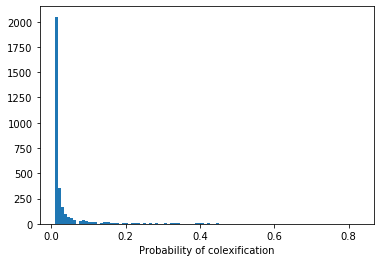

In [813]:
ax = plt.hist(C.values(), bins=100)
plt.xlabel('Probability of colexification')

Text(0, 0.5, '$|log(p(colex))|$')

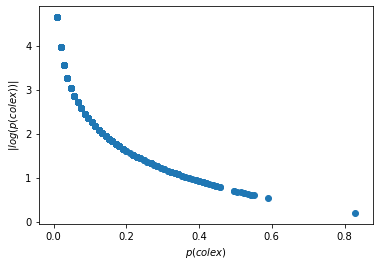

In [814]:
ax = plt.scatter(list(C.values()), [abs(np.log(x)) for x in list(C.values())])
plt.xlabel('$p(colex)$')
plt.ylabel('$|log(p(colex))|$')

In [815]:
def jaccard_similarity(list1, list2, shared):
    intersection = len(shared)
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

$WMCD(L_1, L_2, P) = \frac{\sum_i |log P(L_1 \cup L_2)|}{|L_1| + |L_2| }$

In [853]:
def WMCD(l_1, l_2, C=C, inverse=True):
    if (len(l_2) + len(l_2)) != 0:
        shared = list(set(l_1) & set(l_2))
        if len(shared) == 0:
            return 0
        prob = []
        for el in shared:
            p = C.get(el)
            if inverse:
                prob.append(1-p)
            else:
                prob.append(p)
        return 2 * sum(prob)/(len(l_1) + len(l_2))
    else:
        return 0

Retrieving WMCD, distance and differences in population size for each possible pair of languages (5460 total):

In [817]:
same_family = []
same_genus = []
distance = []
pairs = []
n_of_shared_concepts = []
n_of_c = []
colex_dist = []
colex_dist_i = []
pop_diff = []
sum_of_n_colex = []
jackard = []
family = []

with tqdm(total=len(list(combinations(concepts_2.keys(), r=2)))) as pbar:
    for pair in list(combinations(concepts_2.keys(), r=2)):
        concepts = list(
            set(concepts_2.get(pair[0])) & set(set(concepts_2.get(pair[1]))))

        l_1 = get_colex_lang(pair[0], complete_nel, concepts_2.get(pair[0]))[1]
        l_2 = get_colex_lang(pair[1], complete_nel, concepts_2.get(pair[0]))[1]
        shared = list(set(['{} + {}'.format(i[0], i[1]) for i in l_1])
                      & set(set(['{} + {}'.format(i[0], i[1]) for i in l_2])))

        if complete_nel[complete_nel['Name_y'] == pair[0]].Family.unique() \
                == complete_nel[
            complete_nel['Name_y'] == pair[1]].Family.unique():
            same_family.append('yes')
#             family.append(complete_nel[complete_nel['Name_y'] == pair[0]].Family.unique())
        else:
            same_family.append('no')

        if complete_nel[complete_nel['Name_y'] == pair[0]].Subfamily.unique() \
                == complete_nel[
            complete_nel['Name_y'] == pair[1]].Subfamily.unique():
            same_genus.append('yes')
        else:
            same_genus.append('no')

        try:
            pop_diff.append(
                abs(int(actual_population[actual_population['Language']
                                          == pair[0]]['Population']) -
                    int(actual_population[actual_population['Language']
                                          == pair[1]]['Population'])))
        except:
            pop_diff.append(np.nan)
            pass
        distance.append(distance_nel_km_c[pair[0]][pair[1]])
        pairs.append('{} + {}'.format(pair[0], pair[1]))
        n_of_c.append(len(concepts))
        n_of_shared_concepts.append(len(shared))
        x_0 = ['{} + {}'.format(i[0], i[1]) 
                       for i in l_1]
        x_1 = ['{} + {}'.format(i[0], i[1]) 
                       for i in l_2]
        colex_dist.append(WMCD(x_0, x_1))
        colex_dist_i.append(WMCD(x_0, x_1, inverse=False))
        sum_of_n_colex.append(len(l_1) + len(l_2))
        jackard.append(jaccard_similarity(l_1, l_2, shared))
        pbar.update(1)

<ipython-input-817-c65a26a424ba>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=len(list(combinations(concepts_2.keys(), r=2)))) as pbar:


Making the dataset:

In [831]:
for element in combined.values():
    print(len(element))

5460
5460
5460
5460
5460
5460
5460
5460
5460
5460
1016


In [832]:
combined = {'Pair': pairs,
            'N_sh_colex': n_of_shared_concepts,
            'N_sh_concepts': n_of_c,
            'Distance': distance,
            'Same_family': same_family,
            'Same_genus': same_genus,
            'WMCD': colex_dist,
            'WMCD_i': colex_dist_i,
            'Population_difference': pop_diff,
            'Sum_of_n_colex': sum_of_n_colex,
            'Jaccard': jackard}

results = pd.DataFrame(combined)
sep = pd.DataFrame(results.Pair.str.split('+', 1).tolist(),
                   columns=['Language 1', 'Language 2'])
results = pd.concat([sep, results], axis=1)
results['Language 1'] = results['Language 1'].str.strip()
results['Language 2'] = results['Language 2'].str.strip()
results['Population_difference_log'] = np.log(results['Population_difference'])
results.to_csv('new_results_updated_i.csv')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [834]:
print(pd.read_csv('new_results_updated_i.csv')[['Language 1', 'Language 2', 
                                        'N_sh_colex', 'N_sh_concepts',
                                        'Distance', 'Same_family',
                                        'Same_genus', 'WMCD', 
                                        'Population_difference', 'Jaccard']].sample(5).to_latex())

\begin{tabular}{lllrrrllrrr}
\toprule
{} &              Language 1 &         Language 2 &  N\_sh\_colex &  N\_sh\_concepts &     Distance & Same\_family & Same\_genus &      WMCD &  Population\_difference &   Jaccard \\
\midrule
749  &              Belarusian &  Khalkha Mongolian &          10 &            951 &  5394.202753 &          no &         no &  0.072844 &               100000.0 &  0.072464 \\
2503 &                 English &    Northern Pashto &           2 &            948 &  5799.629204 &         yes &         no &  0.012497 &            379000000.0 &  0.010695 \\
2773 &                 Finnish &           Georgian &          12 &            951 &  2495.921415 &          no &         no &  0.098022 &              2100000.0 &  0.101695 \\
5209 &             Kildin Sami &      Southern Sami &          33 &            937 &  1122.375975 &         yes &        yes &  0.143806 &                  260.0 &  0.118705 \\
2582 &  Central Siberian Yupik &         Portuguese &          

## Adding family

In [835]:
df = pd.read_csv('new_results_updated_i.csv')
dict_fam = pd.Series(complete_nel.Family.values,index=complete_nel.Name_y).to_dict()

df['Family_1'] = df['Language 1'].map(dict_fam) 
df['Family_2'] = df['Language 2'].map(dict_fam) 

In [836]:
len(complete_nel.Family.unique())

21

In [837]:
df.shape

(5460, 17)

In [838]:
df.to_csv('new_results_updated_plus_fam_i.csv')

(array([4.130e+02, 1.547e+03, 1.982e+03, 1.125e+03, 2.940e+02, 8.000e+01,
        1.600e+01, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([0.        , 0.02207483, 0.04414966, 0.06622449, 0.08829932,
        0.11037415, 0.13244898, 0.15452381, 0.17659864, 0.19867347,
        0.2207483 ]),
 <a list of 10 Patch objects>)

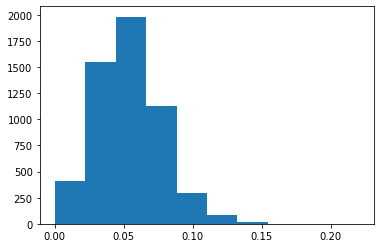

In [840]:
plt.hist(results['WMCD_i'])

Text(0, 0.5, 'WMCD')

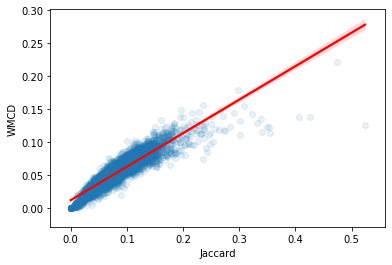

In [844]:
plt.scatter(results['Jaccard'], results['WMCD_i'], alpha=0.1)
sns.regplot(x=results['Jaccard'], y=results['WMCD_i'], scatter=False, color='red')
plt.xlabel('Jaccard')
plt.ylabel('WMCD')

Text(0, 0.5, 'WMCD')

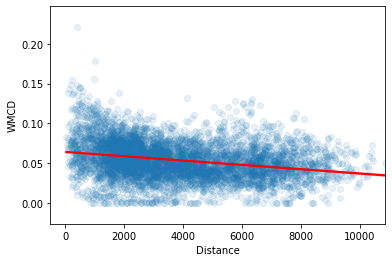

In [845]:
plt.scatter(results['Distance'], results['WMCD_i'], alpha=0.1)
sns.regplot(x=results['Distance'], y=results['WMCD_i'], scatter=False, color='red')
plt.xlabel('Distance')
plt.ylabel('WMCD')

Text(0.5, 0, 'WMCD')

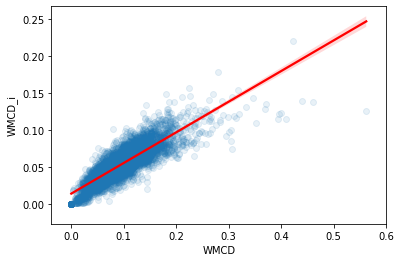

In [846]:
plt.scatter(results['WMCD'], results['WMCD_i'], alpha=0.1)
sns.regplot(x=results['WMCD'], y=results['WMCD_i'], scatter=False, color='red')
plt.ylabel('WMCD_i')
plt.xlabel('WMCD')

In [858]:
import plotly.express as px
df = px.data.tips()

fig = px.density_heatmap(results, x="Distance", y="WMCD", marginal_x="histogram", marginal_y="histogram")
fig.show()

Making the distance matrix:

In [514]:
lgs = list(concepts_2.keys())

distance_matrix = np.zeros((len(lgs), len(lgs)))
xv, yv = np.meshgrid(lgs, lgs, sparse=False, indexing='xy')
for i in range(len(lgs)):
    for j in range(len(lgs)):
        if xv[i, j] != yv[i, j]:
            try:
                distance_matrix[i, j] = \
                    results[(results['Language 1'] == xv[i, j])
                            & (results['Language 2'] == yv[i, j])][
                        'WMCD'].unique()[0]
            except IndexError:
                pass
        else:
            distance_matrix[i, j] = 0

In [515]:
pd.DataFrame(distance_matrix, columns=lgs, index=lgs).to_csv('new_dist_m.csv') 

In [18]:
results = pd.read_csv('new_results_updated_i.csv')

(5460, 15)

In [59]:
lgs = complete_nel[complete_nel['Family'] == 'Indo-European']['Name_y'].unique()

distance_matrix = np.zeros((len(lgs), len(lgs)))
xv, yv = np.meshgrid(lgs, lgs, sparse=False, indexing='xy')
for i in range(len(lgs)):
    for j in range(len(lgs)):
        if xv[i, j] != yv[i, j]:
            try:
                distance_matrix[i, j] = \
                    results[(results['Language 1'] == xv[i, j])
                            & (results['Language 2'] == yv[i, j])][
                        'WMCD'].unique()[0]
            except IndexError:
                pass
        else:
            distance_matrix[i, j] = 0

In [60]:
pd.DataFrame(distance_matrix, columns=lgs, index=lgs).to_csv('WMCD_IE_lgs.csv') 

Getting coordinates:

In [516]:
complete_nel[complete_nel['Name_y'].
             isin([i for i in lgs])][['Name_y',
                                        'Latitude',
                                        'Longitude', 
                                        'Family', 
                                        'Subfamily', 
                                        'Macroarea']].drop_duplicates().to_csv('coords_full.csv')

### 3. Testing for robustness

- redo matrix reduction 
- show sensibility to proba

In [220]:
def delete_one(M, shape=1000):
    M = np.delete(M, -1, axis=0)
    M = np.delete(M, -1, axis=1)
    return M

In [522]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1) & set(list2)))
    union = (len(list1) + len(list2)) - intersection
    if union != 0:
        return float(intersection) / union
    else:
        return 0

In [669]:
def WMCD(l_1, l_2, C=C):
    if (len(l_2) + len(l_2)) != 0:
        shared = list(set(l_1) & set(l_2))
        if len(shared) == 0:
            return 0
        prob = []
        for el in shared:
            p = C.get(el)
            prob.append(1-p)
#         return sum(prob)
        return 2*sum(prob)/((len(l_1) + len(l_2)))
#         return sum(prob)/(len(l_1) + len(l_2))
    else:
        return 0

In [670]:
final = []
final_j = []

for prob in range(1, 11):
    prob = prob/10
    z = 200

    matrices = []
    values = []

    for _ in range(10):
        x = np.random.choice([False, True], size=(z, z), p=[1-prob, prob])
        matrices.append(x)
        values += ['{} + {}'.format(i[0], i[1]) for i in np.argwhere(x).tolist()]

    C = Counter(values)
    total = len(matrices)
    for key in C:
        C[key] /= total

    results = []
    results_j = []

    combs = list(combinations(matrices, r=2))

    with tqdm(total=len(combs)) as pbar:
        for el in list(combs):
            res_j = []
            res = []
            X = el[0]
            Y = el[1]
            for k in range(z):
                x_0 = ['{} + {}'.format(i[0], i[1]) 
                       for i in np.argwhere(X).tolist()]
                x_1 = ['{} + {}'.format(i[0], i[1]) 
                       for i in np.argwhere(Y).tolist()]
                res.append((X.shape[0], WMCD(x_0, x_1, C)))
                res_j.append((X.shape[0], jaccard_similarity(x_0, x_1)))
                X = delete_one(X, shape=z-k)
                Y = delete_one(Y, shape=z-k)
            results.append(res)
            results_j.append(res_j)
            pbar.update(1)
    final_j.append([prob, results_j])
    final.append([prob, results])
    

<ipython-input-670-26290e2e23da>:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=len(combs)) as pbar:


In [671]:
def plot_results(final, name=None):    
    colors = iter(['#420039', '#932F6D', '#E07BE0', '#DCCCFF',
              '#F6F2FF', '#C68866', '#D4AA7D', '#EFD09E', 
              '#D2D8B3', '#B5BA72'])

    fig = plt.figure(figsize=(10, 8))
    for prob in final[0:9]:
        ax = fig.add_subplot(3,3,(prob[0]*10))
        for element in prob[1]: 
            ax.plot(*zip(*element), alpha=0.5, color='black')
            plt.ylim((0, 1))
            ax.set_title('P(colexification) = {}'.format(prob[0]))
        ax.grid()
        mean = np.mean([j for j in list(itertools.chain(*prob[1][0]))[::-2] if j is not None])
        plt.axhline(y=mean, linestyle='--', color='red')
    plt.tight_layout()
    plt.savefig(name, dpi=300)

In [672]:
scores_WMCD = []
scores_j = []

In [673]:
for element in final:
    scores_WMCD.append([i[1] for i in element[1][0]])

In [674]:
for element in final_j:
    scores_j.append([i[1] for i in element[1][0]])

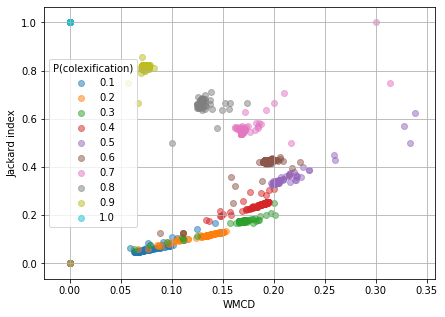

In [675]:
plt.figure(figsize=(7, 5))
for i, j, prob in zip(scores_WMCD, scores_j, [_/10 for _ in (range(1, 11))]):
    plt.scatter(i, j, alpha=0.5, label='{}'.format(prob))
plt.legend(title='P(colexification)')
plt.xlabel('WMCD')
plt.ylabel('Jackard index')
plt.grid()
plt.savefig('WMCD_inverse_jackard.pdf', dpi=300)

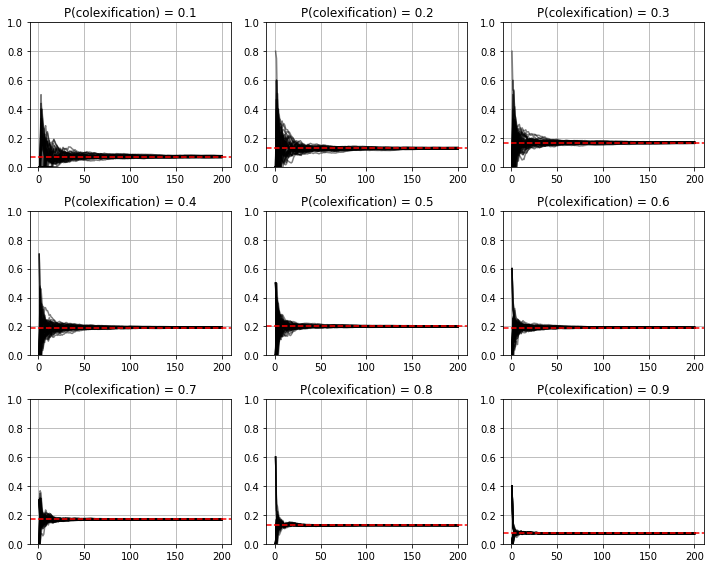

In [676]:
plot_results(final, 'wmcd_robustness_fig.pdf')

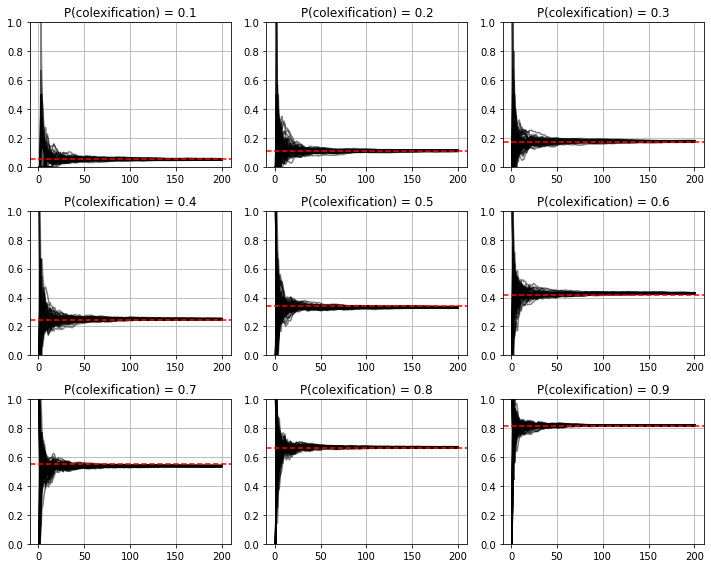

In [677]:
plot_results(final_j, 'jackard_robustness.pdf')

### 4. Retrieving concept info from wordnet

In [11]:
ids = [int(_) for _ in complete_nel['Concepticon_ID'].unique().tolist()]

In [12]:
len(ids)

951

In [40]:
def parce_concepticon(idx):
    try:
        soup = BeautifulSoup(requests.get('https://concepticon.clld.org/parameters/{}'.format(idx)).content)
        links = [x['href'] for x in soup.find_all('a', href=True)]
        link = 0
        for k in links:
            if 'compling' in k:
                link = k
                wnet = BeautifulSoup(requests.get(link).content)
                res = wnet.find('a', text='Semantic Field:').parent.parent.parent.find_all('a')[1]
                return res.text
            else:
                pass
    except:
        return np.nan

In [41]:
parce_concepticon(1007)

'animaln'

In [42]:
concepticon_wn = {}

In [43]:
with tqdm(total=len(ids)) as pbar:
    for ix in ids:
        concepticon_wn[ix] = parce_concepticon(ix)
        time.sleep(0.1)
        pbar.update(1)

<ipython-input-43-422057616879>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=len(ids)) as pbar:


In [52]:
complete_nel.Concepticon_ID = complete_nel.Concepticon_ID.astype(int)

In [53]:
complete_nel['Semantic_field'] = complete_nel.Concepticon_ID.map(concepticon_wn)

In [55]:
complete_nel.Semantic_field.unique()

array(['cognitionv', 'communicationv', None, 'possessionv', 'objectn',
       'plantn', 'bodyn', 'animaln', 'artifactn', 'foodn', 'Topsn',
       'communicationn', 'substancen', 'personn', 'groupn', 'cognitionn',
       'eventn', 'actn', 'quantityn', 'shapen', 'attributen', 'locationn',
       'relationn', 'alla', 'staten', 'possessionn', 'timen', 'allr',
       'phenomenonn', 'contactv', 'motionv', 'changev', 'stativev',
       'weatherv', 'processn', 'bodyv', 'consumptionv', 'socialv',
       'emotionv', 'perceptionv', 'creationv', nan, 'competitionv'],
      dtype=object)

In [58]:
Counter(complete_nel['Semantic_field']).most_common(10)

[(None, 43589),
 ('alla', 9484),
 ('artifactn', 7304),
 ('bodyn', 5050),
 ('contactv', 4307),
 ('animaln', 3877),
 ('motionv', 3466),
 ('personn', 3379),
 ('allr', 3008),
 ('communicationv', 2275)]

In [61]:
complete_nel[complete_nel['Semantic_field'] == 'artifactn']['Name_y'].unique().shape

(105,)

In [62]:
7403/105

70.5047619047619

In [98]:
complete_nel[['Concepticon_Gloss', 'Semantic_field']].drop_duplicates().set_index('Concepticon_Gloss').to_dict().get('Semantic_field')

{'KNOW (SOMETHING)': 'cognitionv',
 'REMEMBER': 'cognitionv',
 'FORGET': 'cognitionv',
 'MEASURE': 'cognitionv',
 'COUNT': 'communicationv',
 'CALCULATE': None,
 'READ': 'cognitionv',
 'SPRING (OF WATER)': None,
 'OWN': 'possessionv',
 'BUY': 'possessionv',
 'SELL': 'possessionv',
 'PAY': 'possessionv',
 'ENDURE': None,
 'RIVER': 'objectn',
 'SHORE OF LAKE': None,
 'COAST': None,
 'MAINLAND': 'objectn',
 'SEA': 'objectn',
 'BAY': 'objectn',
 'ISLAND': 'objectn',
 'FLOWER': 'plantn',
 'FOREHEAD': 'bodyn',
 'GRASS': 'plantn',
 'ROOT': 'plantn',
 'TREE': 'plantn',
 'TREE TRUNK': 'plantn',
 'BARK': 'plantn',
 'BRANCH': 'plantn',
 'TWIG': None,
 'LEAF': 'plantn',
 'BIRCH': 'plantn',
 'PINE': 'plantn',
 'HAIR': 'bodyn',
 'WILLOW': None,
 'FIR': 'plantn',
 'HORN (ANATOMY)': 'animaln',
 'FEATHER': 'animaln',
 'FUR': 'artifactn',
 'WING': 'animaln',
 'CLAW': 'animaln',
 'TAIL': 'animaln',
 'EGG': 'foodn',
 'MOUSTACHE': None,
 'NEST': 'objectn',
 'LAIR': None,
 'ANIMAL': 'Topsn',
 'FLOCK (OF ANI

In [105]:
def get_colex_lang(language, dataframe, conc=None):
    if not conc:
        conc = dataframe[dataframe['Name_y'] == language][
            'Concepticon_Gloss'].unique()
    conc_matrix = pd.DataFrame(np.zeros((len(conc), len(conc))), columns=conc,
                               index=conc)
    lang_df = dataframe[(dataframe['Concepticon_Gloss'].isin(conc)) & (
                dataframe['Name_y'] == language)]
    d = dict()
    for i, values in lang_df[['Form', 'Concepticon_Gloss']].iterrows():
        if values['Form'] not in d.keys():
            d[values['Form']] = [values['Concepticon_Gloss']]
        else:
            d[values['Form']].append(values['Concepticon_Gloss'])
    colex_values = []
    for i, j in d.items():
        if len(j) == 2:
            conc_matrix.at[[j[0]], [j[1]]] = 1
            conc_matrix.at[[j[1]], [j[0]]] = 1
            colex_values += [j]
        elif len(j) > 2:
            for comb in [_ for _ in combinations(j, 2)]:
                conc_matrix.at[[comb[0]], [comb[1]]] = 1
                conc_matrix.at[[comb[1]], [comb[0]]] = 1
                colex_values += [comb]
    colex_values_r = []
    colex_values_field = []
    mapping = complete_nel[['Concepticon_Gloss',
                            'Semantic_field']].drop_duplicates()\
    .set_index('Concepticon_Gloss')\
    .to_dict().get('Semantic_field')
    for pair in colex_values:
        colex_values_r.append(pair[::-1])
        colex_values_field.append([mapping.get(pair[0]), mapping.get(pair[1])])
    return conc_matrix.values, colex_values, colex_values_field

In [107]:
get_colex_lang('Russian', complete_nel)[1]

[['COUNT', 'CALCULATE'],
 ['SPIRIT', 'BREATH'],
 ['LANGUAGE', 'TONGUE'],
 ['COUNT (QUANTITY)', 'AMOUNT'],
 ['HOUSE', 'HOME'],
 ['STOVE', 'BAKE'],
 ['FINGER', 'TOE'],
 ['FINGERNAIL', 'FINGERNAIL OR TOENAIL'],
 ['POUCH', 'SACK'],
 ['BUTTER', 'OIL (ORGANIC SUBSTANCE)'],
 ['LEATHER', 'SKIN'],
 ['PATH OR ROAD', 'ROAD'],
 ['BOW', 'GRASSLAND'],
 ['THIN (OF SHAPE OF OBJECT)', 'FINE OR THIN'],
 ['ALONE', 'ONE'],
 ['CHIME (ACTION)', 'RING (MAKE SOUND)'],
 ['LOVE', 'LIKE'],
 ['PICK UP', 'LIFT'],
 ['TIE', 'KNIT']]

### 5. NPM from Nikolaev, 2019

In [6]:
data = pd.read_csv('NPM_datasets/NPM_distribution_1000.csv')

In [15]:
round(Counter(data['Present']).get(1)/(Counter(data['Present']).get(0)+ Counter(data['Present']).get(1)), 3)*100

8.200000000000001

In [16]:
round(Counter(data['Present']).get(0)/(Counter(data['Present']).get(0)+ Counter(data['Present']).get(1)), 3)*100

91.8

In [196]:
all_colex_langs = []
all_colex = []

for lang in complete_nel.Name_y.unique():
    all_colex += ['{} + {}'.format(i[0], i[1]) 
                     for i in get_colex_lang(lang,
                                             complete_nel)[1]]
    all_colex_langs.append((lang, ['{} + {}'.format(i[0], i[1]) 
                                   for i in get_colex_lang(lang, complete_nel)[1]]))

In [198]:
c_colex = Counter(all_colex)

In [215]:
colex_df = pd.DataFrame(columns=list(c_colex), index=complete_nel.Name_y.unique())
colex_df = colex_df.fillna(0)

In [224]:
for lang in all_colex_langs:
    for colexification in lang[1]:
        colex_df[colexification][lang[0]] = 1

In [239]:
distance_m = pd.read_csv('new_km_dist.csv', index_col='Unnamed: 0')
distance_m = distance_m.mask(distance_m <= 1000, 1)
distance_m = distance_m.mask(distance_m > 1000, 0)

,Abkhaz,Adyghe,Hokkaido Ainu,Aleut,Avar,North Azerbaijani,Bashkir,Belarusian,Bengali,Breton,...,Telugu,Turkish,Udmurt,Ukrainian,Northern Uzbek,Veps,Kalmyk,Northern Yukaghir,Tundra Nenets,Southern Yukaghir
Abkhaz,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Adyghe,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Hokkaido Ainu,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aleut,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Avar,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Veps,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Kalmyk,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Northern Yukaghir,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
Tundra Nenets,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [242]:
G = nx.from_pandas_adjacency(distance_m)
label_mapping = {idx: val for idx, val in enumerate(distance_m.columns)}
G = nx.relabel_nodes(G, label_mapping)

In [246]:
len(nx.shortest_path(G, source='Russian', target='Abkhaz'))

4

In [254]:
def NPM(lang, feature):
    res = []
    for lang_ in colex_df.index[colex_df[feature] == 1].tolist():
        try:
            res.append(1/2**len(nx.shortest_path(G, source=lang, target=lang_)))
        except:
            pass
    return sum(res)

In [601]:
round(NPM('Russian', 'FINGERNAIL + FINGERNAIL OR TOENAIL'), 3)

7.234

In [596]:
round(NPM('French', 'DO + MAKE'), 3)

4.332

In [678]:
npm = []
f = []
sf = []
feature = []
lang = []
prob = []
present = []

for colex in [_[0] for _ in c_colex.most_common(1098)]:
    lgs = colex_df.index[colex_df[colex] == 1].tolist()
    for l in colex_df.index.tolist():
        npm.append(NPM(l, colex))
        f.append(complete_nel[complete_nel['Name_y'] == l].Family.unique()[0])
        sf.append(complete_nel[complete_nel['Name_y'] == l].Subfamily.unique()[0])
        feature.append(colex)
        lang.append(l)
        prob.append(c_colex.get(colex)/105)
        if l in lgs:
            present.append(1)
        else:
            present.append(0)

In [679]:
results_npm = pd.DataFrame({'Feature': feature, 
                            'Language': lang, 
                            'NPM': npm, 
                            'Family': f, 
                            'Subfamily': sf,
                            'Prob': prob, 'Present': present})

In [680]:
results_npm.shape

(115290, 7)

In [681]:
results_npm.to_csv('NPM_distribution.csv')

In [683]:
combined = results_npm.groupby('Feature').mean().reset_index()  
combined = combined.sort_values(by='NPM', ascending=False).reset_index().drop(['index'], axis=1)
combined['Log_NPM'] = np.log(combined['NPM'])

(-10, 1110)

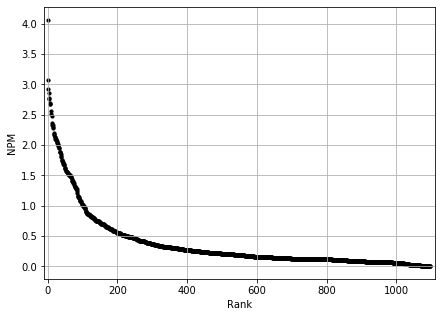

In [784]:
plt.figure(figsize=(7, 5))
plt.grid()
plt.scatter([_ for _ in range(1098)], combined['NPM'], color='black', alpha=1, s=10)
plt.xlabel('Rank')
plt.ylabel('NPM')
plt.xlim(-10, 1110)

Text(0.5, 0, 'Probability')

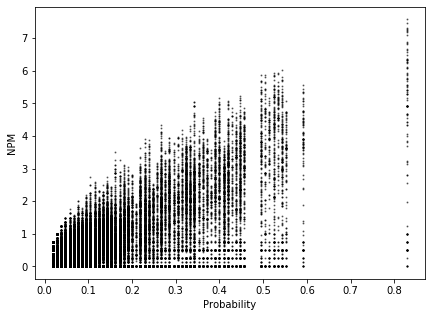

In [794]:
plt.figure(figsize=(7, 5))
plt.scatter(results_npm['Prob'], results_npm['NPM'], s=1, color='black', alpha=0.5)
plt.ylabel('NPM')
plt.xlabel('Probability')

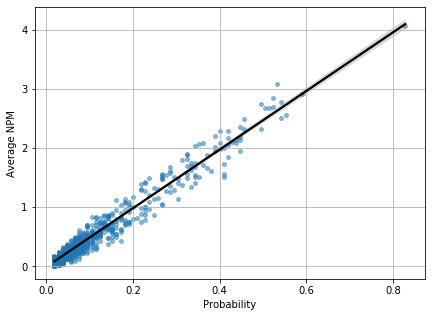

In [686]:
plt.figure(figsize=(7, 5))
plt.scatter(combined['Prob'], combined['NPM'], alpha=0.5, s=15)
sns.regplot(data=combined, x='Prob', y='NPM', scatter=False, color='black')
plt.ylabel('Average NPM')
plt.xlabel('Probability')
plt.grid()

In [773]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.metrics.cluster import contingency_matrix
from statsmodels.stats.contingency_tables import mcnemar

In [717]:
y = results_npm['Present']
X_max = pd.concat([results_npm[['NPM', 'Prob']], 
               pd.get_dummies(results_npm['Family']),
               pd.get_dummies(results_npm['Subfamily'])], axis=1)
X_no_npm = pd.concat([results_npm['Prob'], pd.get_dummies(results_npm['Family']),
               pd.get_dummies(results_npm['Subfamily'])], axis=1)
X_npm = results_npm[['NPM']]
X_rand = results_npm[['NPM']].sample(n=results_npm.shape[0]).reset_index().drop(['index'], axis=1)
X_rand_full = pd.concat([X_rand, 
               pd.get_dummies(results_npm['Family']),
               pd.get_dummies(results_npm['Subfamily'])], axis=1, ignore_index=True)

In [795]:
results_npm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115290 entries, 0 to 115289
Data columns (total 7 columns):
Feature      115290 non-null object
Language     115290 non-null object
NPM          115290 non-null float64
Family       115290 non-null object
Subfamily    115290 non-null object
Prob         115290 non-null float64
Present      115290 non-null int64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.2+ MB


In [690]:
# params_gb = {"max_depth": [1, 2, 3, 4, 5, 6], 
#              "n_estimators": [20, 50, 75, 100, 150, 200, 250, 300, 500, 1000], 
#              "random_state": [42]}

In [703]:
sc = []

for set_ in [X_max, X_no_npm, X_npm, X_rand, X_rand_full]:
    X_train, X_test, y_train, y_test = train_test_split(set_, y, test_size=0.33, random_state=42)
    scores = cross_validate(GradientBoostingClassifier(), X_train, y_train, scoring=['roc_auc', 'recall', 'neg_log_loss'], cv=3)
    sc.append(scores)

In [708]:
[round(np.mean(_.get('test_roc_auc')), 5) for _ in sc]

[0.94986, 0.60254, 0.93424, 0.49618, 0.59976]

In [707]:
[round(np.mean(_.get('test_recall')), 5) for _ in sc]

[0.43076, 0.0, 0.31037, 0.00011, 0.0]

In [709]:
[round(np.mean(_.get('test_neg_log_loss')), 5) for _ in sc]

[-0.39496, -0.26437, -0.50376, -0.26907, -0.26472]

In [737]:
X_train, X_test, y_train, y_test = train_test_split(X_max, y, test_size=0.33, random_state=42)
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))
res_1 = clf.predict(X_test)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     35089
           1       0.79      0.49      0.61      2957

    accuracy                           0.95     38046
   macro avg       0.88      0.74      0.79     38046
weighted avg       0.95      0.95      0.95     38046



In [738]:
X_train, X_test, y_train, y_test = train_test_split(X_no_npm, y, test_size=0.33, random_state=42)
clf_2 = GradientBoostingClassifier()
clf_2.fit(X_train, y_train)
print(classification_report(y_test, clf_2.predict(X_test)))
res_2 = clf_2.predict(X_test)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     35089
           1       0.65      0.08      0.14      2957

    accuracy                           0.93     38046
   macro avg       0.79      0.54      0.55     38046
weighted avg       0.91      0.93      0.90     38046



In [745]:
results = pd.DataFrame({'True': y_test, 'Clf_1': res_2, 'Clf_2': res_1})

In [768]:
results.loc[results['True'] == results.Clf_1, 'Clf_1_correct'] = 1
results.loc[results['True'] != results.Clf_1, 'Clf_1_correct'] = 0
results.loc[results['True'] == results.Clf_2, 'Clf_2_correct'] = 1
results.loc[results['True'] != results.Clf_2, 'Clf_2_correct'] = 0

In [778]:
print(mcnemar(contingency_matrix(results['Clf_2_correct'], results['Clf_1_correct']), correction=True))

pvalue      3.51204380604501e-130
statistic   354.0


In [696]:
len(c_colex) - 2049

1098

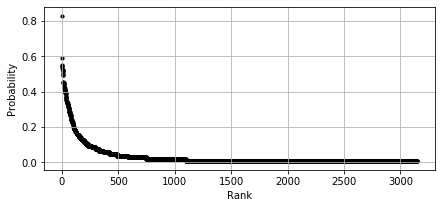

In [666]:
plt.figure(figsize=(7, 3))
plt.grid()
plt.scatter([_ for _ in range(3147)], 
            [i[1]/105 for i in c_colex.most_common(3147)], 
            alpha=1, 
            color='black', 
            s=10)
plt.xlabel('Rank')
plt.ylabel('Probability')
plt.savefig('NPM_rank_prob.pdf', dpi=300)